<a href="https://colab.research.google.com/github/dsobhani8/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs/blob/main/InProgress_ConditionalVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dsobhani8/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs.git

fatal: destination path 'Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs' already exists and is not an empty directory.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import zipfile
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
df_metadata = pd.read_csv('/content/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs/data/rice_sra_with_run_accessions.tsv', sep='\t')
df_metadata['run_accessions'] = df_metadata['run_accessions'].apply(lambda x: x.split(',')[0])

In [ ]:
zip_file_path = '/content/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs/data/combined_counts_matrix.txt.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('combined_counts_matrix.txt') as file:
        df = pd.read_csv(file, sep='\t')


In [ ]:
# Set 'Geneid' as the index to exclude it during transformation (assumed to be gene IDs)
df.set_index('Geneid', inplace=True)
# Transpose the DataFrame so that 'Accession' (samples) become rows and 'Geneid' (genes) become columns
df = df.transpose()

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'Accession'}, inplace=True)

In [ ]:
df_numeric = df.drop(columns=['Accession']).apply(pd.to_numeric, errors='coerce')
df_log = np.log1p(df_numeric)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_log), columns=df_log.columns)
df_scaled.insert(0, 'Accession', df['Accession'])
X = df_scaled.drop(columns=['Accession']).values  # Only the gene expression values
X_tensor = torch.tensor(X, dtype=torch.float32)

In [ ]:
class VAEDataLoader:
    def __init__(self, X, metadata_df=None, batch_size=16, test_size=0.2):
        self.batch_size = batch_size
        self.test_size = test_size

        # Prepare the data and split into train and test sets
        if metadata_df is not None:
            dataset, metadata_encoded, _ = prepare_data(X, metadata_df)
            self.condition_dim = metadata_encoded.shape[1]
        else:
            dataset, _, _ = prepare_data(X)
            self.condition_dim = None

        train_data, test_data = train_test_split(dataset, test_size=self.test_size)

        # Create train and test DataLoaders
        self.train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

    def get_loaders(self):
        return self.train_loader, self.test_loader

    def get_condition_dim(self):
        return self.condition_dim


class FlexibleVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10, hidden_dim=128, condition_dim=None):
        super(FlexibleVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.condition_dim = condition_dim
        self.is_conditional = condition_dim is not None

        # Encoder
        encoder_input_dim = input_dim + (condition_dim if self.is_conditional else 0)
        self.encoder = nn.Sequential(
            nn.Linear(encoder_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        decoder_input_dim = latent_dim + (condition_dim if self.is_conditional else 0)
        self.decoder = nn.Sequential(
            nn.Linear(decoder_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x, c=None):
        if self.is_conditional and c is not None:
            x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        return self.fc_mean(h), self.fc_logvar(h)

    def decode(self, z, c=None):
        if self.is_conditional and c is not None:
            z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * torch.clamp(logvar, min=-10, max=10))
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c=None):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

def create_metadata_encodings(df):
    """Create simple one-hot encodings for each unique experimental factor"""
    processed_factors = df['experiment_attribute'].apply(process_experimental_factors)

    # Just use MultiLabelBinarizer directly on processed factors
    mlb = MultiLabelBinarizer()
    factor_encodings = pd.DataFrame(
        mlb.fit_transform(processed_factors),
        columns=mlb.classes_,
        index=df.index
    )
    # print(f"\nMetadata encoding shape: {factor_encodings.shape}")
    # print("\nFirst few rows of encoded metadata:")
    # print(factor_encodings.head())
    # print("\nUnique factors:")
    # print(factor_encodings.columns.tolist())


    return factor_encodings, {'all_factors': factor_encodings}  # Keep dict return format for compatibility

def process_experimental_factors(experiment_attribute):
    """Extract experimental factors as single strings"""
    if pd.isna(experiment_attribute):
        return []

    factors = experiment_attribute.split('||')
    processed_factors = []

    for factor in factors:
        factor = factor.strip()
        if factor:  # Keep any non-empty factor
            processed_factors.append(factor)

    return processed_factors


def prepare_data(X, metadata_df=None):
    """Prepare data for VAE training (conditional or non-conditional)"""
    X_tensor = torch.tensor(X, dtype=torch.float32)

    if metadata_df is not None:
        metadata_encoded, encoding_dict = create_metadata_encodings(metadata_df)
        condition_tensor = torch.tensor(metadata_encoded.values, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, condition_tensor)
        return dataset, metadata_encoded, encoding_dict
    else:
        dataset = TensorDataset(X_tensor)
        return dataset, None, None

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """Compute VAE loss"""
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

def train_vae(model, data_loader, num_epochs=10, device="cuda"):
    """Train VAE (handles both conditional and non-conditional)"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        for batch in data_loader:
            if model.is_conditional:
                x, c = batch
                c = c.to(device, torch.float32)
            else:
                x = batch[0]
                c = None

            x = x.to(device, torch.float32)
            optimizer.zero_grad()

            recon_x, mu, logvar = model(x, c)
            loss = vae_loss(recon_x, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

def run_vae_training(df_scaled, df_metadata=None, batch_size=16, num_epochs=10, latent_dim=10):
    """Run VAE training pipeline with optional conditioning"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare features and dataset
    if df_metadata is not None:
        # Merge data for conditional VAE
        merged_df = df_scaled.merge(
            df_metadata,
            left_on='Accession',
            right_on='run_accessions',
            how='inner'
        )

        gene_cols = [col for col in df_scaled.columns if col != 'Accession']
        X = merged_df[gene_cols].values
        metadata_df = merged_df[['experiment_attribute']]
    else:
        X = df_scaled.drop('Accession', axis=1).values
        metadata_df = None

    # Initialize data loader class
    data_loader_class = VAEDataLoader(X, metadata_df, batch_size=batch_size)
    train_loader, test_loader = data_loader_class.get_loaders()
    condition_dim = data_loader_class.get_condition_dim()

    # Initialize the model
    model = FlexibleVAE(
        input_dim=X.shape[1],
        latent_dim=latent_dim,
        condition_dim=condition_dim
    ).to(device)

    # Train the model
    train_vae(model, train_loader, num_epochs=num_epochs, device=device)

    return model, train_loader, test_loader


In [ ]:
def calculate_mse(model, data_loader, device="cuda"):
    """Calculate the Mean Squared Error (MSE) of the VAE reconstructions."""
    model.eval()  # Set model to evaluation mode
    mse_values = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            # Unpack batch data
            if model.is_conditional:
                x, c = batch
                c = c.to(device, torch.float32)
            else:
                x = batch[0]
                c = None

            x = x.to(device, torch.float32)

            # Obtain reconstruction
            recon_x, _, _ = model(x, c)

            # Calculate MSE for the current batch and store it
            batch_mse = mean_squared_error(x.cpu().numpy(), recon_x.cpu().numpy())
            mse_values.append(batch_mse)

    # Average MSE across all batches
    avg_mse = sum(mse_values) / len(mse_values)
    print(f"Average MSE: {avg_mse:.4f}")
    return avg_mse

In [ ]:
def evaluate_vae(model, test_loader, device="cuda"):
    """Evaluate VAE performance on test data using MSE."""
    average_mse = calculate_mse(model, test_loader, device=device)
    print(f"Test MSE: {average_mse:.4f}")
    return average_mse

model, train_loader, test_loader = run_vae_training(df_scaled,num_epochs=25)
test_mse = evaluate_vae(model, test_loader)


Epoch [1/25], Average Loss: 592748.7445
Epoch [2/25], Average Loss: 446046.4919
Epoch [3/25], Average Loss: 420818.5830
Epoch [4/25], Average Loss: 414975.2811
Epoch [5/25], Average Loss: 415121.3269
Epoch [6/25], Average Loss: 408608.1658
Epoch [7/25], Average Loss: 411485.0319
Epoch [8/25], Average Loss: 404025.9364
Epoch [9/25], Average Loss: 405350.9372
Epoch [10/25], Average Loss: 395527.4050
Epoch [11/25], Average Loss: 394100.7297
Epoch [12/25], Average Loss: 387986.4640
Epoch [13/25], Average Loss: 371672.1369
Epoch [14/25], Average Loss: 366641.2391
Epoch [15/25], Average Loss: 360571.3326
Epoch [16/25], Average Loss: 358900.7441
Epoch [17/25], Average Loss: 350711.1786
Epoch [18/25], Average Loss: 352023.2955
Epoch [19/25], Average Loss: 342410.5199
Epoch [20/25], Average Loss: 334395.0319
Epoch [21/25], Average Loss: 340057.8727
Epoch [22/25], Average Loss: 338080.9266
Epoch [23/25], Average Loss: 334024.1656
Epoch [24/25], Average Loss: 330317.8005
Epoch [25/25], Average Lo

In [ ]:
model, train_loader, test_loader = run_vae_training(df_scaled,df_metadata=df_metadata,num_epochs=25)
# test_mse = evaluate_vae(model2, test_loader)


Metadata encoding shape: (3176, 47)

First few rows of encoded metadata:
   Experimental Factor: DEVELOPMENTALSTAGE: BCP  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Experimental Factor: DEVELOPMENTALSTAGE: TCP  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Experimental Factor: DEVELOPMENTALSTAGE: UNM  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Ex

In [ ]:
def calculate_correlations(model, data_loader, device="cuda"):
    """Calculate correlations between actual and predicted gene expression values"""
    model.eval()
    all_actual = []
    all_predicted = []

    with torch.no_grad():
        for batch in data_loader:
            if model.is_conditional:
                x, c = batch
                c = c.to(device, torch.float32)
            else:
                x = batch[0]
                c = None

            x = x.to(device, torch.float32)
            recon_x, _, _ = model(x, c)

            all_actual.append(x.cpu().numpy())
            all_predicted.append(recon_x.cpu().numpy())

    actual = np.concatenate(all_actual, axis=0)
    predicted = np.concatenate(all_predicted, axis=0)

    pearson_corrs = []
    spearman_corrs = []

    for i in range(actual.shape[1]):  # For each gene
        # Check if the gene has variation
        if np.std(actual[:, i]) > 1e-10 and np.std(predicted[:, i]) > 1e-10:
            pearson_corr = pearsonr(actual[:, i], predicted[:, i])[0]
            spearman_corr = spearmanr(actual[:, i], predicted[:, i])[0]
        else:
            # Skip constant genes
            pearson_corr = np.nan
            spearman_corr = np.nan

        pearson_corrs.append(pearson_corr)
        spearman_corrs.append(spearman_corr)

    # Filter out NaN values for statistics
    valid_pearson = [x for x in pearson_corrs if not np.isnan(x)]
    valid_spearman = [x for x in spearman_corrs if not np.isnan(x)]

    print("\nCorrelation Statistics:")
    print(f"Number of genes with variation: {len(valid_pearson)} out of {len(pearson_corrs)}")
    print(f"Mean Pearson correlation: {np.mean(valid_pearson):.4f}")
    print(f"Median Pearson correlation: {np.median(valid_pearson):.4f}")
    print(f"Mean Spearman correlation: {np.mean(valid_spearman):.4f}")
    print(f"Median Spearman correlation: {np.median(valid_spearman):.4f}")

    return pearson_corrs, spearman_corrs

Average MSE: 0.4809


<ipython-input-13-e7cc581cf125>:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr = pearsonr(actual[:, i], predicted[:, i])[0]
<ipython-input-13-e7cc581cf125>:32: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = spearmanr(actual[:, i], predicted[:, i])[0]



Correlation Statistics:
Number of genes with variation: 34028 out of 37600
Mean Pearson correlation: 0.6862
Median Pearson correlation: 0.7798
Mean Spearman correlation: 0.3675
Median Spearman correlation: 0.3658


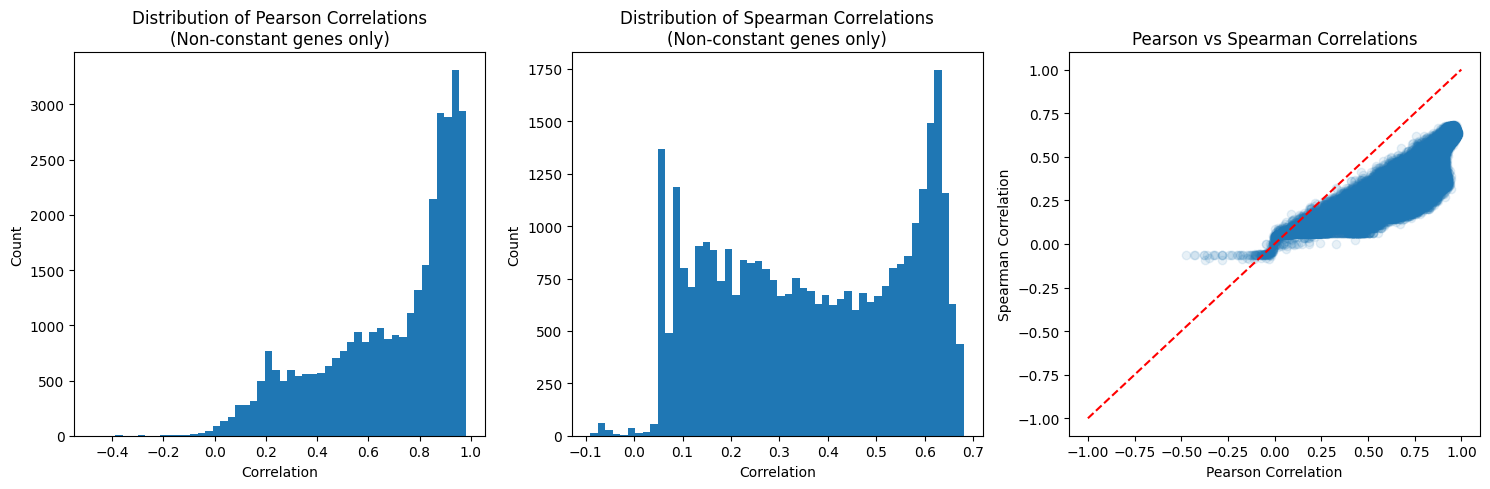

In [ ]:
# Calculate MSE and correlations
mse = calculate_mse(model, test_loader, device)
pearson_corrs, spearman_corrs = calculate_correlations(model, test_loader, device)

# Visualization
plt.figure(figsize=(15, 5))

# Plot Pearson correlations
plt.subplot(1, 3, 1)
valid_pearson = [x for x in pearson_corrs if not np.isnan(x)]
plt.hist(valid_pearson, bins=50)
plt.title('Distribution of Pearson Correlations\n(Non-constant genes only)')
plt.xlabel('Correlation')
plt.ylabel('Count')

# Plot Spearman correlations
plt.subplot(1, 3, 2)
valid_spearman = [x for x in spearman_corrs if not np.isnan(x)]
plt.hist(valid_spearman, bins=50)
plt.title('Distribution of Spearman Correlations\n(Non-constant genes only)')
plt.xlabel('Correlation')
plt.ylabel('Count')

# Optional: Scatter plot of Pearson vs Spearman
plt.subplot(1, 3, 3)
valid_indices = [i for i in range(len(pearson_corrs))
                if not (np.isnan(pearson_corrs[i]) or np.isnan(spearman_corrs[i]))]
valid_pearson = [pearson_corrs[i] for i in valid_indices]
valid_spearman = [spearman_corrs[i] for i in valid_indices]
plt.scatter(valid_pearson, valid_spearman, alpha=0.1)
plt.title('Pearson vs Spearman Correlations')
plt.xlabel('Pearson Correlation')
plt.ylabel('Spearman Correlation')
plt.plot([-1, 1], [-1, 1], 'r--')  # diagonal line

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"MSE: {mse:.4f}")
print(f"Number of genes analyzed: {len(valid_pearson)}")
print(f"Mean Pearson correlation: {np.mean(valid_pearson):.4f}")
print(f"Mean Spearman correlation: {np.mean(valid_spearman):.4f}")
print(f"Percentage of constant genes: {100 * (1 - len(valid_pearson)/len(pearson_corrs)):.2f}%")

In [ ]:
# # Save numerical results to a text file
# with open('vae_performance_results.txt', 'w') as f:
#     f.write("VAE Performance Results\n")
#     f.write("======================\n\n")
#     f.write(f"Mean Squared Error: {mse:.4f}\n\n")
#     f.write("Gene Coverage:\n")
#     f.write(f"Total genes: {len(pearson_corrs)}\n")
#     f.write(f"Genes with variation: {len(valid_pearson)}\n")
#     f.write(f"Percentage constant genes: {100 * (1 - len(valid_pearson)/len(pearson_corrs)):.2f}%\n\n")
#     f.write("Correlation Statistics:\n")
#     f.write(f"Mean Pearson correlation: {np.mean(valid_pearson):.4f}\n")
#     f.write(f"Median Pearson correlation: {np.median(valid_pearson):.4f}\n")
#     f.write(f"Mean Spearman correlation: {np.mean(valid_spearman):.4f}\n")
#     f.write(f"Median Spearman correlation: {np.median(valid_spearman):.4f}\n")

# # Save plot with high resolution
# plt.figure(figsize=(15, 5))

# # Plot Pearson correlations
# plt.subplot(1, 3, 1)
# plt.hist(valid_pearson, bins=50)
# plt.title('Distribution of Pearson Correlations\n(Non-constant genes only)')
# plt.xlabel('Correlation')
# plt.ylabel('Count')

# # Plot Spearman correlations
# plt.subplot(1, 3, 2)
# plt.hist(valid_spearman, bins=50)
# plt.title('Distribution of Spearman Correlations\n(Non-constant genes only)')
# plt.xlabel('Correlation')
# plt.ylabel('Count')

# # Scatter plot of Pearson vs Spearman
# plt.subplot(1, 3, 3)
# plt.scatter(valid_pearson, valid_spearman, alpha=0.1)
# plt.title('Pearson vs Spearman Correlations')
# plt.xlabel('Pearson Correlation')
# plt.ylabel('Spearman Correlation')
# plt.plot([-1, 1], [-1, 1], 'r--')

# plt.tight_layout()

# # Save high-resolution plot
# plt.savefig('vae_correlations.png', dpi=300, bbox_inches='tight')
# plt.savefig('vae_correlations.pdf', bbox_inches='tight')  # Vector format for publication
# plt.close()

# # Optionally save raw correlation data
# results_df = pd.DataFrame({
#     'pearson_correlation': pearson_corrs,
#     'spearman_correlation': spearman_corrs
# })
# results_df.to_csv('correlation_results.csv')